In [2]:
import yfinance as yf
yf.pdr_override()

from pandas_datareader.data import Options
from dateutil.parser import parse
from datetime import datetime
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata
from scipy.stats import norm
import pandas as pd
import quantutils.dataset.pipeline as ppl
from quantutils.api.datasource import MarketDataStore
import plotly.graph_objects as go

In [3]:
def CND(X):
   return float(norm.cdf(X))

In [4]:
def BlackScholes(p,v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
    
    #print(str(p) + " " + str(v) + " " + str(S) + " " + str(X) + " " + str(T))
    try:
        d1 = (log(S/X)+(r+v*v/2.)*T)/(v*sqrt(T))
        d2 = d1-v*sqrt(T)
        
        if CallPutFlag=='c':
            return S*CND(d1)-X*exp(-r*T)*CND(d2)
        else:
            return X*exp(-r*T)*CND(-d2)-S*CND(-d1)
        
    except:
        print("Error during BS calc " + e)
        return 0

In [5]:
def plot3D(X,Y,Z):
   fig = plt.figure()
   ax = Axes3D(fig, azim = -29, elev = 50)
 
   ax.plot(X,Y,Z,'o')
 
   plt.xlabel("expiry")
   plt.ylabel("strike")
   plt.show()

In [6]:
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.01, inc = 0.001):
  
   f = lambda x: BlackScholes(price,x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price
  
   return optimize.brentq(f,-5., 5.)

In [7]:
import py_vollib.black_scholes_merton.implied_volatility as iv
import py_vollib_vectorized

#vols = iv.implied_volatility(result["prices"]["ask"]["Close"].values, 9136.5, 8500, 0.093, 0.0, 'c', q=0)
#implied_volatility(price, S, K, t, r, q, flag)

In [8]:
def get_surf(optionData):
 
   vals = []
 
   for index, row in optionData.iterrows():
      if row['type'].lower() == 'p':
         underlying = float(row['underlying'])
         price = (float(row['ask'])+float(row['bid']))/2.0
         expd = (row['expiry'] - datetime.now()).days
         exps = (row['expiry'] - datetime.now()).seconds
         exp = (expd*24.*3600. + exps) / (365.*24.*3600.)
         try:
            #impl = calc_impl_vol(float(row['ask']), 'c', underlying, float(row['strike']), exp)          
            impl = iv.implied_volatility([price], float(row['underlying']), float(row['strike']), exp, 0.01, 'p', q=0).values[0][0]
            #impl = float(row['impliedVolatility'])
            vals.append([exp,float(row['strike']),impl])
         except(e):
            print("Error " + e)
            pass
 
   vals = array(vals).T
   return vals

In [109]:
def get_surf_IG(optionData):
    
    #price = optionData[["ask", "bid"]].max(axis=1)
    exp = [(exp.days*24.*3600. + exp.seconds) / (365.*24.*3600.) for exp in (optionData['expiry'].sub(optionData['Date_Time']))]
    try:
        impl = iv.implied_volatility(optionData["ask"]*10.0, optionData["underlying"]*10.0, optionData["strike"], exp, 0.01, optionData["type"], q=0)
    except(e):
        print("Error " + e)
    pass

    optionData["impl"] = impl["IV"].values
    optionData["timeToExpiry"] = np.array(exp) * 365

    return optionData

In [10]:
def make_surf(X,Y,Z):
   XX,YY = meshgrid(linspace(min(X),max(X),230),linspace(min(Y),max(Y),230))
   ZZ = griddata(array([X,Y]).T,array(Z),(XX,YY), method='linear')
   return XX,YY,ZZ

In [11]:
def plot3D(X,Y,Z,fig,ax):
   ax.plot(X,Y,Z,'o', color = 'pink')
   plt.xlabel("expiry")
   plt.ylabel("strike")
   
def mesh_plot2(X,Y,Z,fig,ax):
 
   XX,YY,ZZ = make_surf(X,Y,Z)
   ax.plot_surface(XX,YY,ZZ)
   #ax.contour(XX,YY,ZZ)
   plt.xlabel("expiry")
   plt.ylabel("strike")
 
def combine_plots(X,Y,Z):
   fig = plt.figure(figsize=(20, 10))
   ax = Axes3D(fig, azim = -60)
   mesh_plot2(X,Y,Z,fig,ax)
   plot3D(X,Y,Z,fig,ax)
   plt.show()

In [12]:
class MIOptions:
    
    def __init__(self, symbol):

        optionsX = pd.DataFrame()
        stocklist = [symbol]
        for x in stocklist:
            tk = yf.Ticker(x)  
            exps = tk.options  #expiration dates
            try:
                underlying = yf.download(tickers=symbol, period="1d", interval="1d", prepost=False)["Close"].values[0]
                
                for e in exps:
                    print(e)
                    opt = tk.option_chain(e)
                    opt.calls["type"] = "call"
                    opt.puts["type"] = "put"
                    opt = pd.DataFrame().append(opt.calls).append(opt.puts)
                    opt['expiry'] = datetime.strptime(e + " 21:00:00", "%Y-%m-%d %H:%M:%S")
                    opt['ticker'] = x
                    opt["underlying"] = underlying                    
                    optionsX = optionsX.append(opt, ignore_index=True)
            except(e):
                print("Error " + e)
            
        self.option = optionsX
            
    def get_all_data(self):
        return self.option


In [76]:
options = pd.read_pickle("tmp.pkl")
optionData = options.reset_index().set_index("Date_Time").loc["2022-09-14":].reset_index()


In [97]:
calls

Date_Time       epic   Open   High    Low  Close  \
56    2022-09-14 00:00:00+00:00  CLV2|545C  33.98  33.98  33.98  33.98   
58    2022-09-14 00:00:00+00:00  CLV2|550C  33.48  33.48  33.48  33.48   
69    2022-09-14 00:00:00+00:00  CLV2|600C  28.46  28.48  28.46  28.48   
74    2022-09-14 00:00:00+00:00  CLV2|620C  26.48  26.48  26.48  26.48   
76    2022-09-14 00:00:00+00:00  CLV2|625C  25.98  25.98  25.98  25.98   
...                         ...        ...    ...    ...    ...    ...   
51630 2021-07-26 00:00:00+00:00  CLV2|700C   4.99   4.99   4.99   4.99   
51631 2021-07-23 00:00:00+00:00  CLV2|700C   5.06   5.06   5.06   5.06   
51632 2021-07-22 00:00:00+00:00  CLV2|700C   5.05   5.05   5.05   5.05   
51633 2021-07-21 00:00:00+00:00  CLV2|700C   4.90   4.90   4.90   4.90   
51634 2021-07-20 00:00:00+00:00  CLV2|700C   4.18   4.18   4.18   4.18   

       Volume  OpenInterest                    instrumentName  strike type  \
56        0.0           3.0  Crude Oil WTI Oct '22 545.0 Call   545.0    c   
58        0.0           4.0  Crude Oil WTI Oct '22 550.0 Call   550.0    c   
69        1.0           1.0  Crude Oil WTI Oct '22 600.0 Call   600.0    c   
74        0.0           0.0  Crude Oil WTI Oct '22 620.0 Call   620.0    c   
76        0.0           0.0  Crude Oil WTI Oct '22 625.0 Call   625.0    c   
...       ...           ...                               ...     ...  ...   
51630     0.0          20.0  Crude Oil WTI Oct '22 700.0 Call   700.0    c   
51631     0.0          20.0  Crude Oil WTI Oct '22 700.0 Call   700.0    c   
51632     0.0          20.0  Crude Oil WTI Oct '22 700.0 Call   700.0    c   
51633     0.0          20.0  Crude Oil WTI Oct '22 700.0 Call   700.0    c   
51634     0.0          20.0  Crude Oil WTI Oct '22 700.0 Call   700.0    c   

       underlying    ask    bid     expiry underlyingSymbol      impl  
56          88.48  33.98  33.98 2022-09-15            CLV22       NaN  
58          88.48  33.48  33.48 2022-09-15            CLV22       NaN  
69          88.48  28.48  28.48 2022-09-15            CLV22       NaN  
74          88.48  26.48  26.48 2022-09-15            CLV22       NaN  
76          88.48  25.98  25.98 2022-09-15            CLV22       NaN  
...           ...    ...    ...        ...              ...       ...  
51630       64.09   4.99   4.99 2022-09-15            CLV22  0.256810  
51631       64.04   5.06   5.06 2022-09-15            CLV22  0.259218  
51632       63.88   5.05   5.05 2022-09-15            CLV22  0.261134  
51633       63.08   4.90   4.90 2022-09-15            CLV22  0.268202  
51634       60.85   4.18   4.18 2022-09-15            CLV22  0.275230  

[27706 rows x 17 columns]

In [110]:
optionData = get_surf_IG(optionData)
puts = optionData[optionData["type"]=="p"]
calls = optionData[optionData["type"]=="c"]

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [56, 58, 69, 74, 76, 78, 80, 83, 85, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 473, 475, 486, 491, 493, 495, 497, 500, 502, 505, 507, 509, 511, 513, 515, 517, 519, 521, 523, 525, 527, 529, 531, 890, 892, 903, 908, 910, 912, 914, 917, 919, 922, 924, 926, 928, 930, 1307, 1309, 1320, 1325, 1327, 1329, 1331, 1334, 1336, 1339, 1341, 1343, 1345, 1724, 1726, 1737, 1742, 1744, 1746, 2141, 2143, 2558, 2560, 2571, 2576, 2578, 2580, 2582, 2585, 2975, 2977, 2988, 3392, 3394, 3405, 3809, 3811, 3822, 3827, 3829, 4226, 4228, 4239, 4244, 4246, 4248, 4643, 4645, 4656, 4661, 4663, 4665, 4667, 4670, 4672, 4675, 4677, 4679, 4681, 4683, 5060, 5062, 5073, 5078, 5080, 5082, 5084, 5477, 5479, 5490, 5495, 5497, 5499, 5894, 5896, 5907, 5912, 5914, 5916, 5918, 6311,

In [111]:
import plotly.express as px
px.scatter(optionData, x="strike", y="impl", animation_frame="timeToExpiry")

In [103]:
plots = calls[calls["Date_Time"] == "2022-06-01"]
plots2 = calls[calls["Date_Time"] == "2022-09-14"]

fig = go.Figure([go.Scatter(x=plots["strike"], y=plots["impl"]),go.Scatter(x=plots2["strike"], y=plots2["impl"])])
fig.show()

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qt Q12 Qz Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 780357986  delaunay  Qtriangulate  Q12-allow-wide  Qz-infinity-point
  Qcoplanar-keep  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 9.5e+03  Error-roundoff 2e-11  _one-merge 1.4e-10
  Visible-distance 4e-11  U-max-coplanar 4e-11  Width-outside 8e-11
  _wide-facet 2.4e-10  _maxoutside 1.6e-10

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p95(v4):  0.11 9.8e+03 4.9e+03
- p162(v3):  0.11 1.4e+04 1.3e+04
- p0(v2):  0.11 5e+03     0
- p163(v1):  0.11 9.2e+03 1.5e+04

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2e-11.  The center point, facets and distances
to the center point are as follows:

center point   0.1118     9607     8112

facet p162 p0 p163 distance= -2.3e-17
facet p95 p0 p163 distance= -1.4e-17
facet p95 p162 p163 distance= -2.4e-17
facet p95 p162 p0 distance= -8.3e-17

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    0.1118    0.1118  difference= 3.053e-16
  1:      5000  1.45e+04  difference= 9500
  2:         0  1.45e+04  difference= 1.45e+04

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 2e-11.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


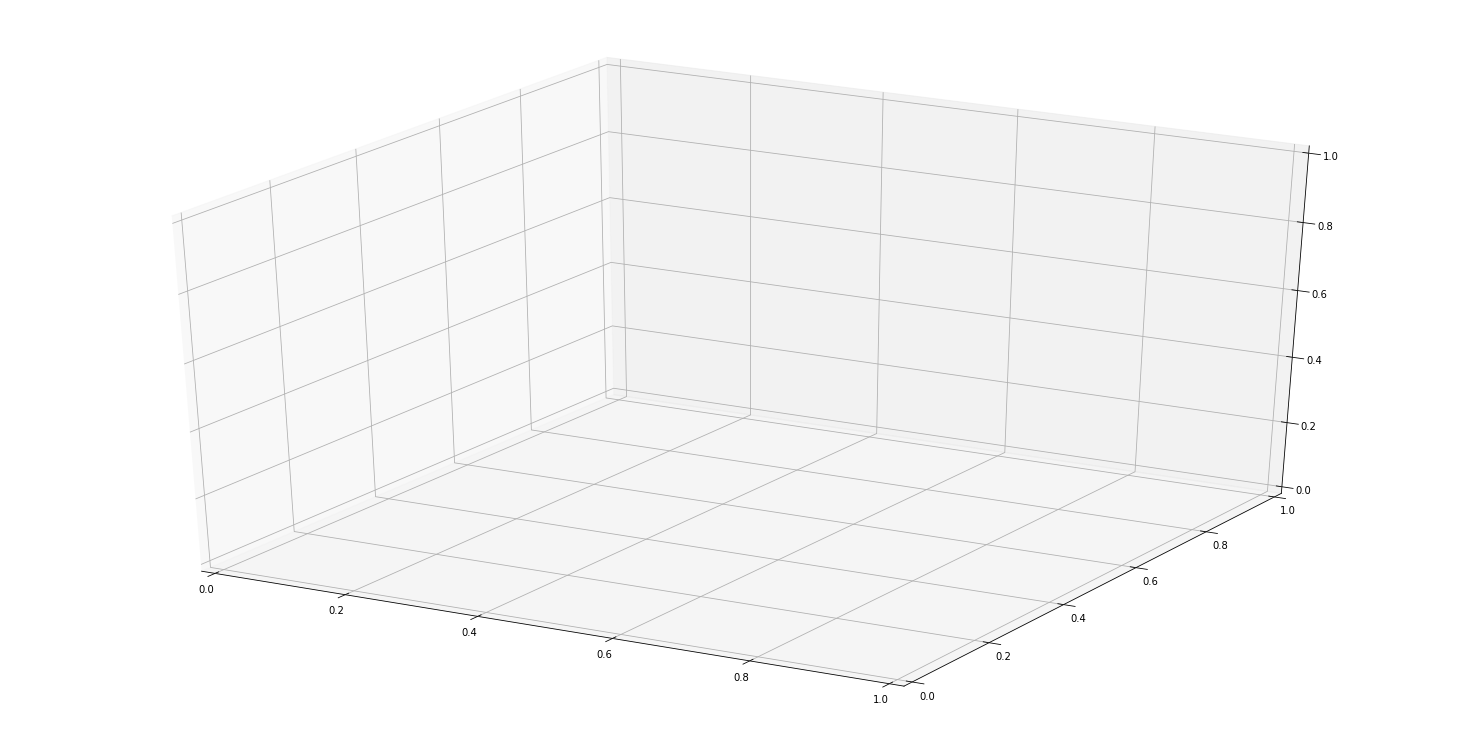

In [22]:
combine_plots(vals[0],vals[1],vals[2])

In [21]:
#z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

xx,yy,zz = make_surf(vals[0], vals[1], vals[2])
fig = go.Figure(data=[go.Surface(z=zz, x=xx, y=yy)])
fig.update_layout(title='MSFT', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qt Q12 Qz Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 780257144  delaunay  Qtriangulate  Q12-allow-wide  Qz-infinity-point
  Qcoplanar-keep  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 9.5e+03  Error-roundoff 2e-11  _one-merge 1.4e-10
  Visible-distance 4e-11  U-max-coplanar 4e-11  Width-outside 8e-11
  _wide-facet 2.4e-10  _maxoutside 1.6e-10

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p95(v4):  0.11 9.8e+03 4.9e+03
- p162(v3):  0.11 1.4e+04 1.3e+04
- p0(v2):  0.11 5e+03     0
- p163(v1):  0.11 9.2e+03 1.5e+04

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2e-11.  The center point, facets and distances
to the center point are as follows:

center point   0.1118     9607     8112

facet p162 p0 p163 distance= -2.3e-17
facet p95 p0 p163 distance= -1.4e-17
facet p95 p162 p163 distance= -2.4e-17
facet p95 p162 p0 distance= -8.3e-17

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    0.1118    0.1118  difference= 3.053e-16
  1:      5000  1.45e+04  difference= 9500
  2:         0  1.45e+04  difference= 1.45e+04

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 2e-11.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [78]:
make_surf(vals[0],vals[1],vals[2])[2]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [138]:
BlackScholes(26.15, 5.,CallPutFlag="p",S=155.80999755859375,X=305.0,T=0.03340959538305429,r=0.01) - 26.15

26.15 5.0 155.80999755859375 305.0 0.03340959538305429


148.2173281731498

In [140]:
BlackScholes(26.15, 0.,CallPutFlag="p",S=155.80999755859375,X=305.0,T=0.03340959538305429,r=0.01) 

26.15 0.0 155.80999755859375 305.0 0.03340959538305429


/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


149.08812019565863

In [10]:
class MIOptions:
    
    def __init__(self, symbol):

        optionsX = pd.DataFrame()
        stocklist = [symbol]
        for x in stocklist:
            tk = yf.Ticker(x)  
            exps = tk.options  #expiration dates
            try:
                underlying = yf.download(tickers=symbol, period="1d", interval="1d", prepost=False)["Close"].values[0]
                
                for e in exps:
                    print(e)
                    opt = tk.option_chain(e)
                    opt.calls["type"] = "call"
                    opt.puts["type"] = "put"
                    opt = pd.DataFrame().append(opt.calls).append(opt.puts)
                    opt['expiry'] = datetime.strptime(e + " 21:00:00", "%Y-%m-%d %H:%M:%S")
                    opt['ticker'] = x
                    opt["underlying"] = underlying                    
                    optionsX = optionsX.append(opt, ignore_index=True)
            except(e):
                print("Error " + e)
            
        self.option = optionsX[optionsX["strike"]<350]
            
    def get_all_data(self):
        return self.option


In [35]:
tk = yf.Ticker("AAPL") 
opt = tk.option_chain("2023-06-16")
opt

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0   AAPL230616C00060000 2022-09-02 19:24:10+00:00    60.0      96.80  96.90   
1   AAPL230616C00065000 2022-08-30 14:49:05+00:00    65.0      94.80  92.15   
2   AAPL230616C00070000 2022-09-01 16:05:12+00:00    70.0      89.15  87.45   
3   AAPL230616C00075000 2022-09-01 16:06:47+00:00    75.0      82.90  82.80   
4   AAPL230616C00080000 2022-09-02 16:41:12+00:00    80.0      80.40  78.20   
5   AAPL230616C00085000 2022-09-02 17:52:03+00:00    85.0      73.93  73.65   
6   AAPL230616C00090000 2022-09-02 19:50:10+00:00    90.0      68.93  69.10   
7   AAPL230616C00095000 2022-09-01 15:47:08+00:00    95.0      64.49  64.65   
8   AAPL230616C00100000 2022-09-02 14:06:36+00:00   100.0      60.62  60.30   
9   AAPL230616C00105000 2022-09-02 14:06:36+00:00   105.0      58.83  56.00   
10  AAPL230616C00110000 2022-08-29 15:50:51+00:00   110.0      56.70  51.80   
11  AAPL230616C00115000 2022-09-02 14:

In [32]:
option = MIOptions("AAPL")
data = option.get_all_data()


[*********************100%***********************]  1 of 1 completed
2022-09-09
2022-09-16
2022-09-23
2022-09-30
2022-10-07
2022-10-21
2022-11-18
2022-12-16
2023-01-20
2023-02-17
2023-03-17
2023-04-21
2023-06-16
2023-07-21
2023-09-15
2024-01-19
2024-06-21


In [33]:
data

contractSymbol             lastTradeDate  strike  lastPrice  \
0     AAPL220909C00070000 2022-09-02 15:04:07+00:00    70.0      89.70   
1     AAPL220909C00075000 2022-08-31 19:54:40+00:00    75.0      83.20   
2     AAPL220909C00080000 2022-08-30 13:48:16+00:00    80.0      81.30   
3     AAPL220909C00085000 2022-08-30 13:58:22+00:00    85.0      76.25   
4     AAPL220909C00090000 2022-09-02 16:45:26+00:00    90.0      67.65   
...                   ...                       ...     ...        ...   
1605  AAPL240621P00270000 2022-08-30 14:43:10+00:00   270.0     111.20   
1606  AAPL240621P00280000 2022-08-24 16:06:22+00:00   280.0     111.70   
1607  AAPL240621P00290000 2022-08-17 15:36:24+00:00   290.0     116.30   
1608  AAPL240621P00300000 2022-09-02 16:31:50+00:00   300.0     141.70   
1609  AAPL240621P00320000 2022-08-15 16:52:25+00:00   320.0     147.00   

         bid     ask     change  percentChange  volume  openInterest  \
0      85.80   85.95   2.849998       3.281518     1.0          26.0   
1      80.80   80.95   0.000000       0.000000     6.0          57.0   
2      75.80   76.00   0.000000       0.000000     4.0          28.0   
3      70.80   71.00   0.000000       0.000000     4.0           7.0   
4      65.80   66.00  -3.699997      -5.185700     1.0          62.0   
...      ...     ...        ...            ...     ...           ...   
1605  113.75  114.55   0.000000       0.000000     1.0           0.0   
1606  123.80  124.55   0.000000       0.000000     2.0           0.0   
1607  133.80  134.60   0.000000       0.000000     2.0           0.0   
1608  143.75  144.55  10.699997       8.167936     4.0           0.0   
1609  163.50  164.60   0.000000       0.000000     4.0           4.0   

      impliedVolatility  inTheMoney contractSize currency  type  \
0              2.492191        True      REGULAR      USD  call   
1              2.289067        True      REGULAR      USD  call   
2              2.187505        True      REGULAR      USD  call   
3              2.000005        True      REGULAR      USD  call   
4              1.828126        True      REGULAR      USD  call   
...                 ...         ...          ...      ...   ...   
1605           0.200081        True      REGULAR      USD   put   
1606           0.210945        True      REGULAR      USD   put   
1607           0.224983        True      REGULAR      USD   put   
1608           0.230965        True      REGULAR      USD   put   
1609           0.253670        True      REGULAR      USD   put   

                  expiry ticker  underlying  
0    2022-09-09 21:00:00   AAPL  155.809998  
1    2022-09-09 21:00:00   AAPL  155.809998  
2    2022-09-09 21:00:00   AAPL  155.809998  
3    2022-09-09 21:00:00   AAPL  155.809998  
4    2022-09-09 21:00:00   AAPL  155.809998  
...                  ...    ...         ...  
1605 2024-06-21 21:00:00   AAPL  155.809998  
1606 2024-06-21 21:00:00   AAPL  155.809998  
1607 2024-06-21 21:00:00   AAPL  155.809998  
1608 2024-06-21 21:00:00   AAPL  155.809998  
1609 2024-06-21 21:00:00   AAPL  155.809998  

[1551 rows x 18 columns]

In [55]:
from datetime import datetime
datetime.strptime("2012-01-02 21:00:00", "%Y-%m-%d %H:%M:%S")

datetime.datetime(2012, 1, 2, 21, 0)

In [223]:
!pip install --upgrade scipy

     |████████████████████████████████| 25.9 MB 4.1 MB/s            
  Attempting uninstall: scipy
    Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
